# 実験環境

In [2]:
import time
import os
import pyhocon
import torch
import argparse
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import glob
import os, re, json
import matplotlib.pyplot as plt
import jsonlines
import random
import torch.nn.functional as F
import math
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from monai.losses.dice import GeneralizedDiceLoss

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')

In [4]:
torch.cuda.is_available()

True

## データ処理

In [5]:
data_url_repo = "../../data/corpus/*"
data_url_dir = glob.glob(data_url_repo)

In [6]:
EOS_token = '<EOS>'
BOS_token = '<BOS>'
file_pattern = re.compile(r'^sw\_([a-z]+?)\_([0-9]+?)\.jsonlines$')

swda_tagu = {
    '<Uninterpretable>': ['abandoned_or_turn-exit/uninterpretable', 'non-verbal'],
    '<Statement>': ['statement-non-opinion', 'statement-opinion', 'other_answers', '3rd-party-talk', 'self-talk', 'offers,_options_commits', 'collaborative_completion'],
    '<Question>': ['yes-no-question', 'wh-question', 'declarative_yes-no-question', 'backchannel_in_question_form', 'open-question', 'rhetorical-questions', 'signal-non-understanding', 'or-clause', 'tag-question', 'declarative_wh-question'],
    '<Directive>': ['action-directive'],
    '<Greeting>': ['conventional-opening', 'conventional-closing'],
    '<Apology>': ['apology', 'no_answers', 'reject', 'negative_non-no_answers', 'dispreferred_answers', 'dispreferred_answers'],
    '<Agreement>': ['agree/accept', 'maybe/accept-part', 'thanking'],
    '<Understanding>': ['acknowledge_(backchannel)', 'summarize/reformulate', 'appreciation', 'response_acknowledgement', 'affirmative_non-yes_answers', 'yes_answers'],
    '<Other>': ['other', 'hedge', 'quotation', 'repeat-phrase', 'hold_before_answer/agreement', 'downplayer']
}

daily_tagu = {1: "inform", 2: "question", 3: "directive", 4: "commissive"}

### 対話行為のID化

In [7]:
class DA_to_ID:
    
    def __init__(self, config, X_DA, Y_DA, name):
        self.word2id = None
        self.id2word = None
        self.config = config
        self.X_DA = X_DA
        self.Y_DA = Y_DA
        self.name = name
        self.construct()
        
    def construct(self):
        vocab = {}
        vocab_count = {}
        
        for x,y in zip(self.X_DA, self.Y_DA):
            for token in x:
                if token in vocab_count:
                    vocab_count[token] += 1
                else:
                    vocab_count[token] = 1
                    
            for token in y:
                if token in vocab_count:
                    vocab_count[token] += 1
                else:
                    vocab_count[token] = 1
                    
        for k, _ in sorted(vocab_count.items(), key=lambda x: -x[1]):
            vocab[k] = len(vocab)
            if len(vocab) >= self.config[self.name]['MAX_VOCAB']: break
        self.word2id = vocab
        self.id2word = {v : k for k, v in vocab.items()}
        return vocab
        
    def tokenize(self, X_tensor, Y_tensor):
        X_Tensor = [[self.word2id[token] for token in sentence] for sentence in X_tensor]
        Y_Tensor = [[self.word2id[token] for token in sentence] for sentence in Y_tensor]
        return X_Tensor, Y_Tensor

### 発話のID化

In [8]:
class UTT_to_ID:
    
    def __init__(self, config, X_UTT, Y_UTT, name):
        self.word2id = None
        self.id2word = None
        self.config = config
        self.X_UTT = X_UTT
        self.Y_UTT = Y_UTT
        self.name = name
        self.construct()
        
    def construct(self):
        
        vocab = {'<UNK>': 0, '<EOS>': 1, '<BOS>': 2, '<UttPAD>': 3, '<ConvPAD>': 4}
        vocab_count = {}
        
        for x,y in zip(self.X_UTT, self.Y_UTT):
            for seq in x:
                for word in seq:
                    if word in vocab_count:
                        vocab_count[word] += 1
                    else:
                        vocab_count[word] = 1
            for seq in y:
                for word in seq:
                    if word in vocab_count:
                        vocab_count[word] += 1
                    else:
                        vocab_count[word] = 1
                        
        for k, _ in sorted(vocab_count.items(), key=lambda x: -x[1]):
            vocab[k] = len(vocab)
            if len(vocab) >= self.config[self.name]['UTT_MAX_VOCAB']: break
        self.word2id = vocab
        self.id2word = {v : k for k, v in vocab.items()}

        return vocab
        
    def tokenize(self, X_tensor, Y_tensor):
        
        X_Tensor = [[[self.word2id[token] if token in self.word2id else self.word2id['<UNK>'] for token in seq] for seq in dialogue] for dialogue in X_tensor]
        Y_Tensor = [[[self.word2id[token] if token in self.word2id else self.word2id['<UNK>'] for token in seq] for seq in dialogue] for dialogue in Y_tensor]
        return X_Tensor, Y_Tensor

### トレーニングデータ作成

In [9]:
def create_traindata(config, name):
    files = [f for f in os.listdir(config[name]['train_path']) if file_pattern.match(f)]
    
    da_x, da_y, utt_x, utt_y, turn = [], [], [], [], []
    # 1file 1conversation
    for filename in files:
        # print(os.path.join(config['train_path'], filename))
        with open(os.path.join(config[name]['train_path'], filename), 'r') as f:
            data = f.read().split('\n')
            data.remove('')
            da_seq, utt_seq, turn_seq = [], [], []
            # 1line 1turn
            for idx, line in enumerate(data, 1):
                jsondata = json.loads(line)
                # single-turn multi dialogue case
                if config[name]['multi_dialogue']:
                    for da, utt in zip(jsondata['DA'], jsondata['sentence']):
                        da_seq.append(da)
                        utt_seq.append(utt.split(' '))
                        turn_seq.append(0)
                    if config[name]['turn']:
                        da_seq.append('<turn>')
                        utt_seq.append('<turn>')
                    turn_seq[-1] = 1
                # single-turn single dialogue case
                else:
                    da_seq.append(jsondata['DA'][-1])
                    utt_seq.append(jsondata['sentence'][-1].split(' '))
            da_seq = [easy_damsl(da) for da in da_seq]
            assert len(turn_seq) == len(da_seq), '{} != {}'.format(len(turn_seq), len(da_seq))
        
        
        if config[name]['state']:
            for i in range(max(1, len(da_seq) - 1 - config[name]['window_size'])):
                if len(da_seq)>=config[name]['window_size']:
                    da_x.append(da_seq[i:min(len(da_seq)-1, i + config[name]['window_size'])])
                    da_y.append(da_seq[1 + i:min(len(da_seq), 1 + i + config[name]['window_size'])])
                    utt_x.append(utt_seq[i:min(len(da_seq)-1, i + config[name]['window_size'])])
                    utt_y.append(utt_seq[1 + i:min(len(da_seq), 1 + i + config[name]['window_size'])])
                    turn.append(turn_seq[i:min(len(da_seq), i + config[name]['window_size'])])
                
        else:
            da_x.append(da_seq[:-1])
            da_y.append(da_seq[1:])
            utt_x.append(utt_seq[:-1])
            utt_y.append(utt_seq[1:])
            turn.append(turn_seq[:-1])
    
    assert len(da_x) == len(da_y), 'Unexpect length da_posts and da_cmnts'
    assert len(utt_x) == len(utt_y), 'Unexpect length utt_posts and utt_cmnts'
    assert len(turn) == len(da_x)
    
    return da_x, da_y, utt_x, utt_y, turn


### タグ

In [10]:
def easy_damsl(tag):
    easy_tag = [k for k, v in swda_tagu.items() if tag in v]
    return easy_tag[0] if not len(easy_tag) < 1 else tag

### データの分割

In [11]:
def separate_data(x, y, turn):
    split_size = round(len(x) / 10)
    if split_size == 0: split_size = 1
    X_train, Y_train, Tturn = x[split_size * 2:], y[split_size * 2:], turn[split_size * 2:]
    X_valid, Y_valid, Vturn = x[split_size: split_size * 2], y[split_size: split_size * 2], turn[split_size: split_size * 2]
    X_test, Y_test, Testturn = x[:split_size], y[:split_size], turn[:split_size]
    assert len(X_train) == len(Y_train), 'Unexpect to separate train data'
    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test, Tturn, Vturn, Testturn

### 訓練の準備

In [12]:
def initialize_env(name):
    config = pyhocon.ConfigFactory.parse_file('./dialogue.conf')
    config['log_dirs'] = os.path.join(config[name]['log_dir'])
    if not os.path.exists(config['log_dirs']):
        os.mkdir(config['log_dirs'])
     
    return config

In [13]:
def create_DAdata(config, name):
    posts, cmnts, _, _, turn = create_traindata(config, name)
    X_train, Y_train, X_valid, Y_valid, X_test, Y_test, Tturn, Vturn, Testturn = separate_data(posts, cmnts, turn)
    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test, Tturn, Vturn, Testturn

def create_Uttdata(config, name):
    _, _, posts, cmnts, turn = create_traindata(config, name)
    X_train, Y_train, X_valid, Y_valid, X_test, Y_test, _, _, _ = separate_data(posts, cmnts, turn)
    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test


In [14]:
model_name = 'CmbAttention'
# loss_name = "CE_CostMatrix"
# loss_name = "LogAll"
# loss_name = "CE"
# loss_name = "CE_CostMatrix_V2"
loss_name = "CE_weight"
# loss_name = "FL"
# loss_name = "GDiceLoss"

reductions = "mean"
Pramater_N = 4

In [15]:
write = SummaryWriter("./logs")
config = initialize_env(model_name+loss_name)

XDA_train, YDA_train, XDA_valid, YDA_valid, _, _, Tturn, Vturn, _ = create_DAdata(config, model_name+loss_name)
XUtt_train, YUtt_train, XUtt_valid, YUtt_valid, _, _ = create_Uttdata(config, model_name+loss_name)

DA_vocab = DA_to_ID(config, XDA_train+XDA_valid, YDA_train+YDA_valid, model_name+loss_name)
Utt_vocab = UTT_to_ID(config, XUtt_train+XUtt_valid, YUtt_train+YUtt_valid, model_name+loss_name)

XDA_train, YDA_train = DA_vocab.tokenize(XDA_train, YDA_train)
XDA_valid, YDA_valid = DA_vocab.tokenize(XDA_valid, YDA_valid)
XUtt_train, YUtt_train = Utt_vocab.tokenize(XUtt_train, YUtt_train)
XUtt_valid, YUtt_valid = Utt_vocab.tokenize(XUtt_valid, YUtt_valid)

print('Finish preparing dataset...')

Finish preparing dataset...


## モデルの構築

#### Cmb Attention

In [16]:
class CmbAttentionModel(nn.Module):
    
    def __init__(self, model_name, utt_vocab, da_vocab, config, device):
        super(CmbAttentionModel, self).__init__()
        
        self.utter_encoder = UtteraceEncoder(len(utt_vocab.word2id), config[model_name]['UTT_EMBED'], config[model_name]['UTT_HIDDEN'])

        self.context_encoder = RNNContextAwareEncoder(config[model_name]['CON_EMBED'], config[model_name]['CON_HIDDEN'])

        self.da_encoder = RNNDAAwareEncoder(len(utt_vocab.word2id), config[model_name]['DA_EMBED'], config[model_name]['DA_HIDDEN'])

        self.de_encoder = DenceEncoder(config[model_name]['DA_HIDDEN'] + config[model_name]['CON_HIDDEN'], config[model_name]['DA_EMBED'], len(da_vocab.word2id))

        self.device = device
        
    def forward(self, X_utter, X_da, mask, utter_hidden, context_hidden, da_hidden, turn):

        utter_output, utter_weights = self.utter_encoder(X_utter, mask)

        turn_output = torch.cat((utter_output, turn), dim=2)

        context_output, context_weights, context_hidden = self.context_encoder(turn_output, mask, context_hidden)

        da_output, da_weights, da_hidden = self.da_encoder(X_da, mask, da_hidden)

        x_output = torch.cat((context_output, da_output), dim=2)

        dence_output = self.de_encoder(x_output)

        output = dence_output.squeeze(1)  # (batch_size, da_dim)
        
        return output, utter_hidden, context_hidden, da_hidden
    
    def validtion(self, X_utter, X_da, mask, utter_hidden, context_hidden, da_hidden, turn):

        utter_output, utter_weights = self.utter_encoder(X_utter, mask)

        turn_output = torch.cat((utter_output, turn), dim=2)

        context_output, context_weights, context_hidden = self.context_encoder(turn_output, mask, context_hidden)

        da_output, da_weights, da_hidden = self.da_encoder(X_da, mask, da_hidden)

        x_output = torch.cat((context_output, da_output), dim=2)

        dence_output = self.de_encoder(x_output)

        output = dence_output.squeeze(1)  # (batch_size, da_dim)

        return output, utter_hidden, context_hidden, da_hidden


    def prediction(self, X_utter, X_da, mask, utter_hidden, context_hidden, da_hidden, turn):

        utter_output, utter_weights = self.utter_encoder(X_utter, mask)

        turn_output = torch.cat((utter_output, turn), dim=2)

        context_output, context_weights, context_hidden = self.context_encoder(turn_output, mask, context_hidden)

        da_output, da_weights, da_hidden = self.da_encoder(X_da, mask, da_hidden)

        x_output = torch.cat((context_output, da_output), dim=2)

        dence_output = self.de_encoder(x_output)

        output = dence_output.squeeze(1)  # (batch_size, da_dim)

        return output, utter_hidden, context_hidden, da_hidden, utter_weights


    def initDAHidden(self, batch_size):
        return self.utter_encoder.initHidden(batch_size, self.device), self.context_encoder.initHidden(batch_size, self.device), self.da_encoder.initHidden(batch_size, self.device)

#### Model Block

In [17]:
class WordEmbedding(nn.Module):

    def __init__(self, vocab_size, embed_size, w_model):
        super(WordEmbedding, self).__init__()
        self.word_embedding = nn.Embedding(vocab_size, embed_size)
        self.linear = nn.Linear(embed_size, w_model)

    def forward(self, x_word):
        return torch.tanh(self.linear(self.word_embedding(x_word)))

In [18]:
class DAEmbedding(nn.Module):

    def __init__(self, da_size, embed_size, d_model):
        super(DAEmbedding, self).__init__()
        self.da_embedding = nn.Embedding(da_size, embed_size)
        self.linear = nn.Linear(embed_size, d_model)

    def forward(self, x_da):
        return torch.tanh(self.linear(self.da_embedding(x_da)))

In [19]:
class Attention(nn.Module):

    def __init__(self, d_model):
        super(Attention, self).__init__()
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)
        self.d_k = d_model
       
    def forward(self, q, k, v, mask=None):
        # 全結合層で特徴量を変換
        k = self.k_linear(k)
        q = self.q_linear(q)
        v = self.v_linear(v)

        # Attentionの値を計算する
        # 各値を足し算すると大きくなりすぎるので、root(d_k)で割って調整
        weights = torch.matmul(q, k.transpose(1, 2)) / math.sqrt(self.d_k)
        
        # ここでmaskを計算
        if mask is not None:
            mask = mask.unsqueeze(1)
            weights = weights.masked_fill(mask == 0, -1e9)

        # softmaxで規格化をする
        attention_weights = F.softmax(weights, dim=-1)

        # AttentionをValueとかけ算
        output = torch.matmul(attention_weights, v)

        # 全結合層で特徴量を変換
        output = self.out(output)

        return output, attention_weights

In [20]:
class ContextAttention(nn.Module):

    def __init__(self, d_model, hidden_size, att_size):
        super(ContextAttention, self).__init__()
        self.q_linear = nn.Linear(att_size, att_size)
        self.v_linear = nn.Linear(att_size, att_size)
        self.k_linear = nn.Linear(att_size, att_size)

        self.fc_1 = nn.Linear(d_model, d_model)
        self.fc_3 = nn.Linear(hidden_size, d_model, bias=True)
        self.fc_2 = nn.Linear(d_model, att_size)

        self.fc_out = nn.Linear(att_size, hidden_size, bias=True)
        self.d_k = att_size

    def forward(self, x, mask, hidden):
        
        x = self.fc_2(torch.tanh(self.fc_1(x) + self.fc_3(hidden)))

        q = self.q_linear(x)
        v = self.v_linear(x)
        k = self.k_linear(x)

        weights = torch.matmul(q, k.transpose(1, 2)) / math.sqrt(self.d_k)

        # ここでmaskを計算
        if mask is not None:
            mask = mask.unsqueeze(1)
            weights = weights.masked_fill(mask == 0, -1e9)

        attention_weights = F.softmax(weights, dim=-1)

        att_output = torch.matmul(attention_weights, v)

        output = self.fc_out(att_output)

        return output, attention_weights

In [21]:
class FeedForward(nn.Module):

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):

        x = self.linear_1(x)

        x = self.dropout(F.relu(x))

        x = self.linear_2(x)

        return x

In [22]:
class PositinalEncoding(nn.Module):

    def __init__(self, d_model, max_len, dropout=0.1):
        super(PositinalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        
        x = x + self.pe[:x.size(0), :]

        return self.dropout(x)


In [23]:
class DenceEncoder(nn.Module):
    def __init__(self, da_hidden, da_embed_size, da_input_size):
        super(DenceEncoder, self).__init__()
        self.he = nn.Linear(da_hidden, da_embed_size)
        self.ey = nn.Linear(da_embed_size, da_input_size)

    def forward(self, hidden):
        pred = self.ey(torch.tanh(self.he(hidden)))
        return pred


In [24]:
class RNNContextAwareEncoder(nn.Module):
    
    def __init__(self, emb_dim, d_model):
        super(RNNContextAwareEncoder, self).__init__()
        self.d_model = d_model
        self.linear = nn.Linear(self.d_model+1, self.d_model)
        self.rnn = nn.GRU(self.d_model, self.d_model, batch_first=True)
        self.attention = ContextAttention(self.d_model, self.d_model, self.d_model)
        self.ffn = FeedForward(self.d_model, self.d_model)

    def forward(self, x, mask, hidden):

        lin_output = self.linear(x)

        att_output, att_weights = self.attention(lin_output, mask, hidden.transpose(0,1))        

        rnn_output, rnn_hidden = self.rnn(att_output, hidden)

        ffn_output = self.ffn(rnn_output)

        return ffn_output, att_weights, rnn_hidden

    def initHidden(self, batch_size, device):
        return torch.zeros(1, batch_size, self.d_model).to(device)

In [25]:
class RNNDAAwareEncoder(nn.Module):

    def __init__(self, da_size, emb_dim, d_model):
        super(RNNDAAwareEncoder, self).__init__()
        self.d_model = d_model
        self.embedding = DAEmbedding(da_size, emb_dim, self.d_model)
        self.rnn = nn.GRU(self.d_model, self.d_model, batch_first=True)
        self.attention = ContextAttention(self.d_model, self.d_model, self.d_model)
        self.ffn = FeedForward(self.d_model, emb_dim)

    def forward(self, X_da, mask, hidden):

        emb_output = self.embedding(X_da)

        att_output, att_weights = self.attention(emb_output, mask, hidden.transpose(0,1))        

        rnn_output, rnn_hidden = self.rnn(att_output, hidden)

        ffn_output = self.ffn(rnn_output)

        return ffn_output, att_weights, rnn_hidden

    def initHidden(self, batch_size, device):
        return torch.zeros(1, batch_size, self.d_model).to(device)

In [26]:
class UtteraceEncoder(nn.Module):
    
    def __init__(self, vocab_size, emb_dim, d_model):
        super(UtteraceEncoder, self).__init__()
        self.d_model = d_model
        self.embedding = WordEmbedding(vocab_size, emb_dim, self.d_model)
        self.pe = PositinalEncoding(self.d_model, 200)
        self.att = Attention(self.d_model)
        self.ffn = FeedForward(d_model, emb_dim)
        
    def forward(self, x_utter, mask):

        emb_output = self.embedding(x_utter)

        pos_output = self.pe(emb_output)

        att_output, att_weights = self.att(pos_output, pos_output, pos_output, mask)

        ffn_output = self.ffn(att_output)

        seq_len = ffn_output.size()[1]

        avg_output = F.avg_pool2d(ffn_output, (seq_len, 1)) # => (128, 1, 512)

        return avg_output, att_weights  # 発話ベクトル(128, 1, 512)

    def initHidden(self, batch_size, device):
        return torch.zeros(1, batch_size, self.d_model).to(device)

# Cost-Sensitive Learning Loss Function

## コスト値の設定方法

In [27]:
CostMatrixWeight = None

if loss_name == "CE_CostMatrix":
    YDAlist = YDA_train + YDA_valid
    da_list=[0]*9

    for da in YDAlist:
        for d in da:
            da_list[d]+=1

    CostMatrixWeight=[[0 for i in range(9)] for j in range(9)]
    for i in range(len(da_list)):
        for j in range(len(da_list)):
            CostMatrixWeight[i][j] = max(np.log(da_list[j]/da_list[i])*Pramater_N, 1.0) 
            
if loss_name == "CE_CostMatrix_V2":
    CostMatrixWeight = [[0.84646899, 1.13040193, 1.0, 1.01549231, 1.003003, 1.0, 1.00067617, 1.00391783, 1.00003977],
                        [1.181196, 0.80622808, 1.0, 1.00958166, 1.00192489, 1.0, 1.0, 1.00106938, 1.0],
                        [1.78249011, 1.17796263, 0.00893655, 1.0158189, 1.01786445, 1.0, 1.00027274, 1.00518205, 1.00040911],
                        [1.2849671 , 1.59153029, 1.0, 0.12046567, 1.0, 1.0, 1.0, 1.00303695, 1.0],
                        [1.47779112, 1.44657863, 1.0, 1.0090036 , 0.05982393, 1.0, 1.00020008, 1.00660264, 1.0],
                        [1.71856917, 1.24145187, 1.0, 1.01052078, 1.00736454, 0.00893655, 1.0, 1.02209363, 1.0],
                        [1.3458445 , 1.62555853, 1.0, 1.01340483, 1.00268097, 1.0, 0.00893655, 1.00357462, 1.0],
                        [1.14285714, 1.03888419, 1.0, 1.0101437 , 1.0, 1.0, 1.0, 0.80811496, 1.0],
                        [1.74911661, 1.20141343, 1.0, 1.01413428, 1.0, 1.0, 1.0, 1.03533569, 0.00893655]]
    for i in range(9):
        for j in range(9):
            CostMatrixWeight[i][j]=CostMatrixWeight[i][j]**Pramater_N

    
if loss_name == "LogAll":
    class_num_sum=[0]*9
    class_log_all_weight = [0]*9

    for i in range(9):
        for DA in XDA_train:
            for da in DA:
                class_num_sum[da]+=1

    for i in range(9):
        class_log_all_weight[i] = np.log(sum(class_num_sum)/class_num_sum[i])
        
    class_log_all_weights = torch.tensor(class_log_all_weight, dtype=torch.float32)
    
    
if loss_name == "CE_weight":
    if Pramater_N==1:
        class_weights = torch.tensor([1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 4.0])
    if Pramater_N==2:
        class_weights = torch.tensor([1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0])
    if Pramater_N==3:
        class_weights = torch.tensor([1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0])
    if Pramater_N==4:
        class_weights = torch.tensor([1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0])
    if Pramater_N==5:
        class_weights = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0])
    if Pramater_N==6:
        class_weights = torch.tensor([1.0, 1.0, 2.0, 2.0, 4.0, 4.0, 6.0, 6.0, 8.0])
    if Pramater_N==7:
        class_weights = torch.tensor([1.0, 1.0, 2.0, 2.0, 4.0, 4.0, 8.0, 8.0, 8.0])

## 損失関数

In [28]:
class CostMatrixLoss(nn.Module):
    def __init__(self, device, cost_matrix, reductions):
        super(CostMatrixLoss, self).__init__()
        self.base_loss = nn.CrossEntropyLoss(reduction="none")
        self.normalization = nn.Softmax(dim=1)
        self.cost_matrix = torch.Tensor(cost_matrix).to(torch.float64)
        self.reductions = reductions
        
    def forward(self, logit, target):
        base_loss = self.base_loss(logit, target)
        b_loss = base_loss.to(torch.float64)
        pred = torch.argmax(logit.squeeze(1), dim=1)
        cost_mat = torch.tensor([self.cost_matrix[target[i]][pred[i]] for i in range(len(pred))])
        cost_output = torch.matmul(b_loss, cost_mat)
        
        if self.reductions == "sum":
            return cost_output
        elif self.reductions == "mean":
            return cost_output/len(pred)

In [29]:
class Focal_MultiLabel_Loss(nn.Module):
    def __init__(self, gamma):
        super(Focal_MultiLabel_Loss, self).__init__()
        self.gamma = gamma
        self.bceloss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, outputs, targets): 
        bce = self.bceloss(outputs, targets)
        bce_exp = torch.exp(-bce)
        focal_loss = (1-bce_exp)**self.gamma * bce
        return focal_loss.mean()

### モデルの選択

In [30]:
def select_model(mode_name, utt_vocab, da_vocab, config, device, lr, loss_func, cost_matrixs, reductions, Pramater_N):
    
    if model_name == "CmbAttention":
        
        if loss_func == "CE":
            model = CmbAttentionModel(model_name+loss_func, utt_vocab, da_vocab, config, device).to(device)
            opt = optim.Adam(model.parameters(), lr)
            loss_function = nn.CrossEntropyLoss(reduction=reductions).cuda()
        
        if loss_func == "CE_weight":
            model = CmbAttentionModel(model_name+loss_func, utt_vocab, da_vocab, config, device).to(device)
            opt = optim.Adam(model.parameters(), lr)
            loss_function = nn.CrossEntropyLoss(reduction=reductions, weight=class_weights).cuda()
        
        elif loss_func == "Affinity":
            model = CmbAttentionModel_affinity(model_name+loss_func, utt_vocab, da_vocab, config, device).to(device)
            opt = optim.Adam(model.parameters(), lr)
            loss_function = Affinity_Loss(0.95, len(da_vocab.word2id), device)
            
        elif loss_func == "CE_CostMatrix_V2":
            model = CmbAttentionModel(model_name+loss_func, utt_vocab, da_vocab, config, device).to(device)
            opt = optim.Adam(model.parameters(), lr)
            loss_function = CostMatrixLoss(device, cost_matrixs, reductions).to(device)
            
        elif loss_func == "CE_CostMatrix":
            model = CmbAttentionModel(model_name+loss_func, utt_vocab, da_vocab, config, device).to(device)
            opt = optim.Adam(model.parameters(), lr)
            loss_function = CostMatrixLoss(device, cost_matrixs, reductions).to(device)
            
        elif loss_func == "LogAll":
            model = CmbAttentionModel(model_name+loss_func, utt_vocab, da_vocab, config, device).to(device)
            opt = optim.Adam(model.parameters(), lr)
            loss_function = nn.CrossEntropyLoss(reduction=reductions, weight=class_log_all_weights).to(device)
            
        elif loss_func == "CE_CostMatrix":
            model = CmbAttentionModel(model_name+loss_func, utt_vocab, da_vocab, config, device).to(device)
            opt = optim.Adam(model.parameters(), lr)
            loss_function = CostMatrixLoss(device, cost_matrixs, reductions).to(device)
            
        elif loss_func == "FL":
            model = CmbAttentionModel(model_name+loss_func, utt_vocab, da_vocab, config, device).to(device)
            opt = optim.Adam(model.parameters(), lr)
            loss_function = Focal_MultiLabel_Loss(Pramater_N).to(device)
            
        elif loss_func == "GDiceLoss":
            model = CmbAttentionModel(model_name+loss_func, utt_vocab, da_vocab, config, device).to(device)
            opt = optim.Adam(model.parameters(), lr)
            loss_function = GeneralizedDiceLoss(reduction="mean", softmax=True).to(device)
            
    else:
        model = None
        opt = None
        loss_function = None
        
    return model, opt, loss_function

In [31]:
def select(model_name, loss_name, cmx, reductions, n):
    lr = config[model_name+loss_name]['lr']
    batch_size = config[model_name+loss_name]['BATCH_SIZE']

    models, optims, loss_func = select_model(model_name, Utt_vocab, DA_vocab, config, device, lr, loss_name, cmx, reductions, n)   
    return models, optims, loss_func

## モデルの訓練

#### 検証

In [32]:
@torch.no_grad()
def validation(X_valid, Y_valid, XU_valid, YU_valid, model, device, config, turn, batch_size):

    total_loss = 0
    
    idx = 0
    
    index = [i for i in range(len(X_valid))]
    random.shuffle(index)
    
    while idx < len(index):
        step_size = min(batch_size, len(index)-idx)
        print('\r{}/{} conversation evaluating'.format(idx+step_size, len(X_valid)), end='')
        batch_idx = index[idx:idx+step_size]
        Xda_seq = [X_valid[seq_idx] for seq_idx in batch_idx]
        Yda_seq = [Y_valid[seq_idx] for seq_idx in batch_idx]
        turn_seq = [turn[seq_idx] for seq_idx in batch_idx]
        XUtt_seq = [XU_valid[seq_idx] for seq_idx in batch_idx]
        max_conv_len = max(len(s) for s in Xda_seq) 
        for i in range(len(XUtt_seq)):
            XUtt_seq[i] = XUtt_seq[i] + [[Utt_vocab.word2id['<ConvPAD>']]] * (max_conv_len - len(XUtt_seq[i]))
        utter_hidden, context_hidden, da_hidden = model.initDAHidden(step_size)
    
        
        max_conv_len = max(len(s) for s in Xda_seq) 
        for i in range(0, max_conv_len):
            X_tensor = torch.tensor([[X[i]] for X in Xda_seq]).to(device)
            Y_tensor = torch.tensor([[Y[i]] for Y in Yda_seq]).to(device)
            turn_tensor = torch.tensor([[t[i]] for t in turn_seq]).to(device)
            turn_tensor = turn_tensor.float()
            turn_tensor = turn_tensor.unsqueeze(1)    
            max_seq_len = max(len(XU[i]) + 1 for XU in XUtt_seq)
            
            for ci in range(len(XUtt_seq)):
                XUtt_seq[ci][i] = XUtt_seq[ci][i] + [Utt_vocab.word2id['<UttPAD>']] * (max_seq_len - len(XUtt_seq[ci][i]))
            
            XUtt_tensor = torch.tensor([XU[i] for XU in XUtt_seq]).to(device)
            
            output, utter_hidden, context_hidden, da_hidden = model.validtion(XUtt_tensor, X_tensor, None, utter_hidden, context_hidden, da_hidden, turn_tensor)
            
            if loss_name != "GDiceLoss":
                Y_tensor=Y_tensor.squeeze(1)
                
                
            if loss_name == "GDiceLoss":
                Y_tensor = F.one_hot(Y_tensor, num_classes=9)
                Y_tensor = torch.permute(Y_tensor, (0, 2, 1))
                output = output.unsqueeze(dim=2)
            
            loss = loss_func(output.to(device), Y_tensor.to(device)).to(device)
            total_loss += loss.item()

        total_loss/=max_conv_len
        idx += step_size

    return total_loss

#### 訓練

In [33]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [34]:
plot_train_losses = []
plot_valid_losses = []

In [34]:
def Train(model_name, loss_name, models, optims, loss_func):

    plot_train_losses = []
    plot_valid_losses = []

    print_total_loss = 0
    plot_total_loss = 0
    
    _valid_loss = None
    batch_size = config[model_name+loss_name]['BATCH_SIZE']
    
    print('{} start TRAINING'.format(model_name+loss_name))
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    start = time.time()
    
    for epoch in range(config[model_name+loss_name]['EPOCH']):

        tmp_time = time.time()
        print('Epoch {}/'.format(epoch+1) + str(config[model_name+loss_name]['EPOCH']) +' start')
        index = [i for i in range(len(XDA_train))]
        random.shuffle(index)
        idx=0

        while idx < len(index):
            step_size = min(batch_size, len(index)-idx)
            batch_idx = index[idx:idx+step_size]
            utter_hidden, context_hidden, da_hidden = models.initDAHidden(step_size)

            print('\rConversation {}/{} training...'.format(idx + step_size, len(XDA_train)), end='')
            Xda_seq = [XDA_train[seq_idx] for seq_idx in batch_idx]
            Yda_seq = [YDA_train[seq_idx] for seq_idx in batch_idx]
            turn_seq = [Tturn[seq_idx] for seq_idx in batch_idx]
            
            ## 最大対話長(window sizeが決定していない場合は, 各対話の一番長いものが採用される)
            max_conv_len = max(len(s) for s in Xda_seq) 

            ## 
            XUtt_seq = [XUtt_train[seq_idx] for seq_idx in batch_idx]
            YUtt_seq = [YUtt_train[seq_idx] for seq_idx in batch_idx]

            for i in range(len(XUtt_seq)):
                XUtt_seq[i] = XUtt_seq[i] + [[Utt_vocab.word2id['<ConvPAD>']]] * (max_conv_len - len(XUtt_seq[i]))
                YUtt_seq[i] = YUtt_seq[i] + [[Utt_vocab.word2id['<ConvPAD>']]] * (max_conv_len - len(YUtt_seq[i]))

            for ci in range(len(Xda_seq)):
                ### 最大対話長が揃っているから、あまり意味のない処理(全ての対話を使いたい場合は変更)
                turn_seq[ci] = turn_seq[ci] + [0] * (max_conv_len - len(turn_seq[ci]))
                Xda_seq[ci] = Xda_seq[ci] + [0] * (max_conv_len - len(Xda_seq[ci]))
                Yda_seq[ci] = Yda_seq[ci] + [0] * (max_conv_len - len(Yda_seq[ci]))

            for i in range(0, max_conv_len):
                
                last = True if i == max_conv_len - 1 else False
                Xda_tensor = torch.tensor([[X[i]] for X in Xda_seq]).to(device)
                Yda_tensor = torch.tensor([[Y[i]] for Y in Yda_seq]).to(device)
                turn_tensor = torch.tensor([[t[i]] for t in turn_seq]).to(device)
                turn_tensor = turn_tensor.float()
                turn_tensor = turn_tensor.unsqueeze(1)    

                ### 
                max_seq_len = max(len(XU[i]) + 1 for XU in XUtt_seq)
                
                ### Padding処理
                for ci in range(len(XUtt_seq)):
                    XUtt_seq[ci][i] = XUtt_seq[ci][i] + [Utt_vocab.word2id['<UttPAD>']] * (max_seq_len - len(XUtt_seq[ci][i]))
                    YUtt_seq[ci][i] = YUtt_seq[ci][i] + [Utt_vocab.word2id['<UttPAD>']] * (max_seq_len - len(YUtt_seq[ci][i]))
                XUtt_tensor = torch.tensor([XU[i] for XU in XUtt_seq]).to(device)
                YUtt_tensor = None

                output, utter_hidden, context_hidden, da_hidden = models(XUtt_tensor, Xda_tensor, None, utter_hidden, context_hidden, da_hidden, turn_tensor)

                if loss_name != "GDiceLoss":
                    Yda_tensor=Yda_tensor.squeeze(1)  
                
                if loss_name == "GDiceLoss":
                    Yda_tensor = F.one_hot(Yda_tensor, num_classes=9)
                    Yda_tensor = torch.permute(Yda_tensor, (0, 2, 1))
                    output = output.unsqueeze(dim=2)
                
                loss = loss_func(output.to(device), Yda_tensor.to(device)).to(device)
                optims.zero_grad()
                loss.backward(retain_graph=True)
                print_total_loss += loss.item()
                
                if last:
                    optims.step()
                    
            print_total_loss/=max_conv_len  
            idx += step_size

        
        valid_loss = validation(XDA_valid, YDA_valid, XUtt_valid, YUtt_valid, models, device, config, Vturn, batch_size)

        def save_model(filename):
            torch.save(models.state_dict(), os.path.join(config[model_name+loss_name]['log_dir'], config[model_name+loss_name]['SAVE_NAME'] + "_" + str(config[model_name+loss_name]['window_size']) + "_" + reductions + "_Paramater" + str(Pramater_N) + "_Epochs" + str(config[model_name+loss_name]['EPOCH']) + ".model".format(filename)))
#                 torch.save(models.state_dict(), os.path.join(config[model_name+loss_name]['log_dir'], config[model_name+loss_name]['SAVE_NAME'] + "_" + str(config[model_name+loss_name]['window_size']) + reductions +
        print("steps %d\tloss %.4f\tvalid loss %.4f | exec time %.4f" % (epoch+1, print_total_loss, valid_loss, time.time()-tmp_time))
        plot_train_losses.append(print_total_loss)
        plot_valid_losses.append(valid_loss)
        print_total_loss = 0

        if _valid_loss == None:
            save_model("model_save")
            print("Model Saved")
            _valid_loss = valid_loss
        else:
            if valid_loss<_valid_loss:
                _valid_loss = valid_loss
                save_model("model_save")
                print("Model Saved")
    

    return plot_train_losses, plot_valid_losses

In [35]:
models, optims, loss_func = select(model_name, loss_name, CostMatrixWeight, reductions, Pramater_N)
# plot_train_losses, plot_valid_losses = Train(model_name, loss_name, models, optims, loss_func)

### 訓練検証のプロット

In [36]:
def plots(train, valid):
    
    plt.figure(figsize=(40, 30))
    mylist = list(range(config[model_name+loss_name]['EPOCH']))
    # pyplot.plot(x, y)でプロット作成
    plt.plot(mylist, train, label="train plot", c="r")
    plt.plot(mylist, valid, label="valid plot", c="b")
    plt.title("Training Transition")
    plt.xlabel("Number of trainings")
    plt.ylabel("loss")
    plt.legend()
    plt.show()
    # plt.savefig('./data/images/plot/plot_{}.png'.format(loss_name))
    plt.show()

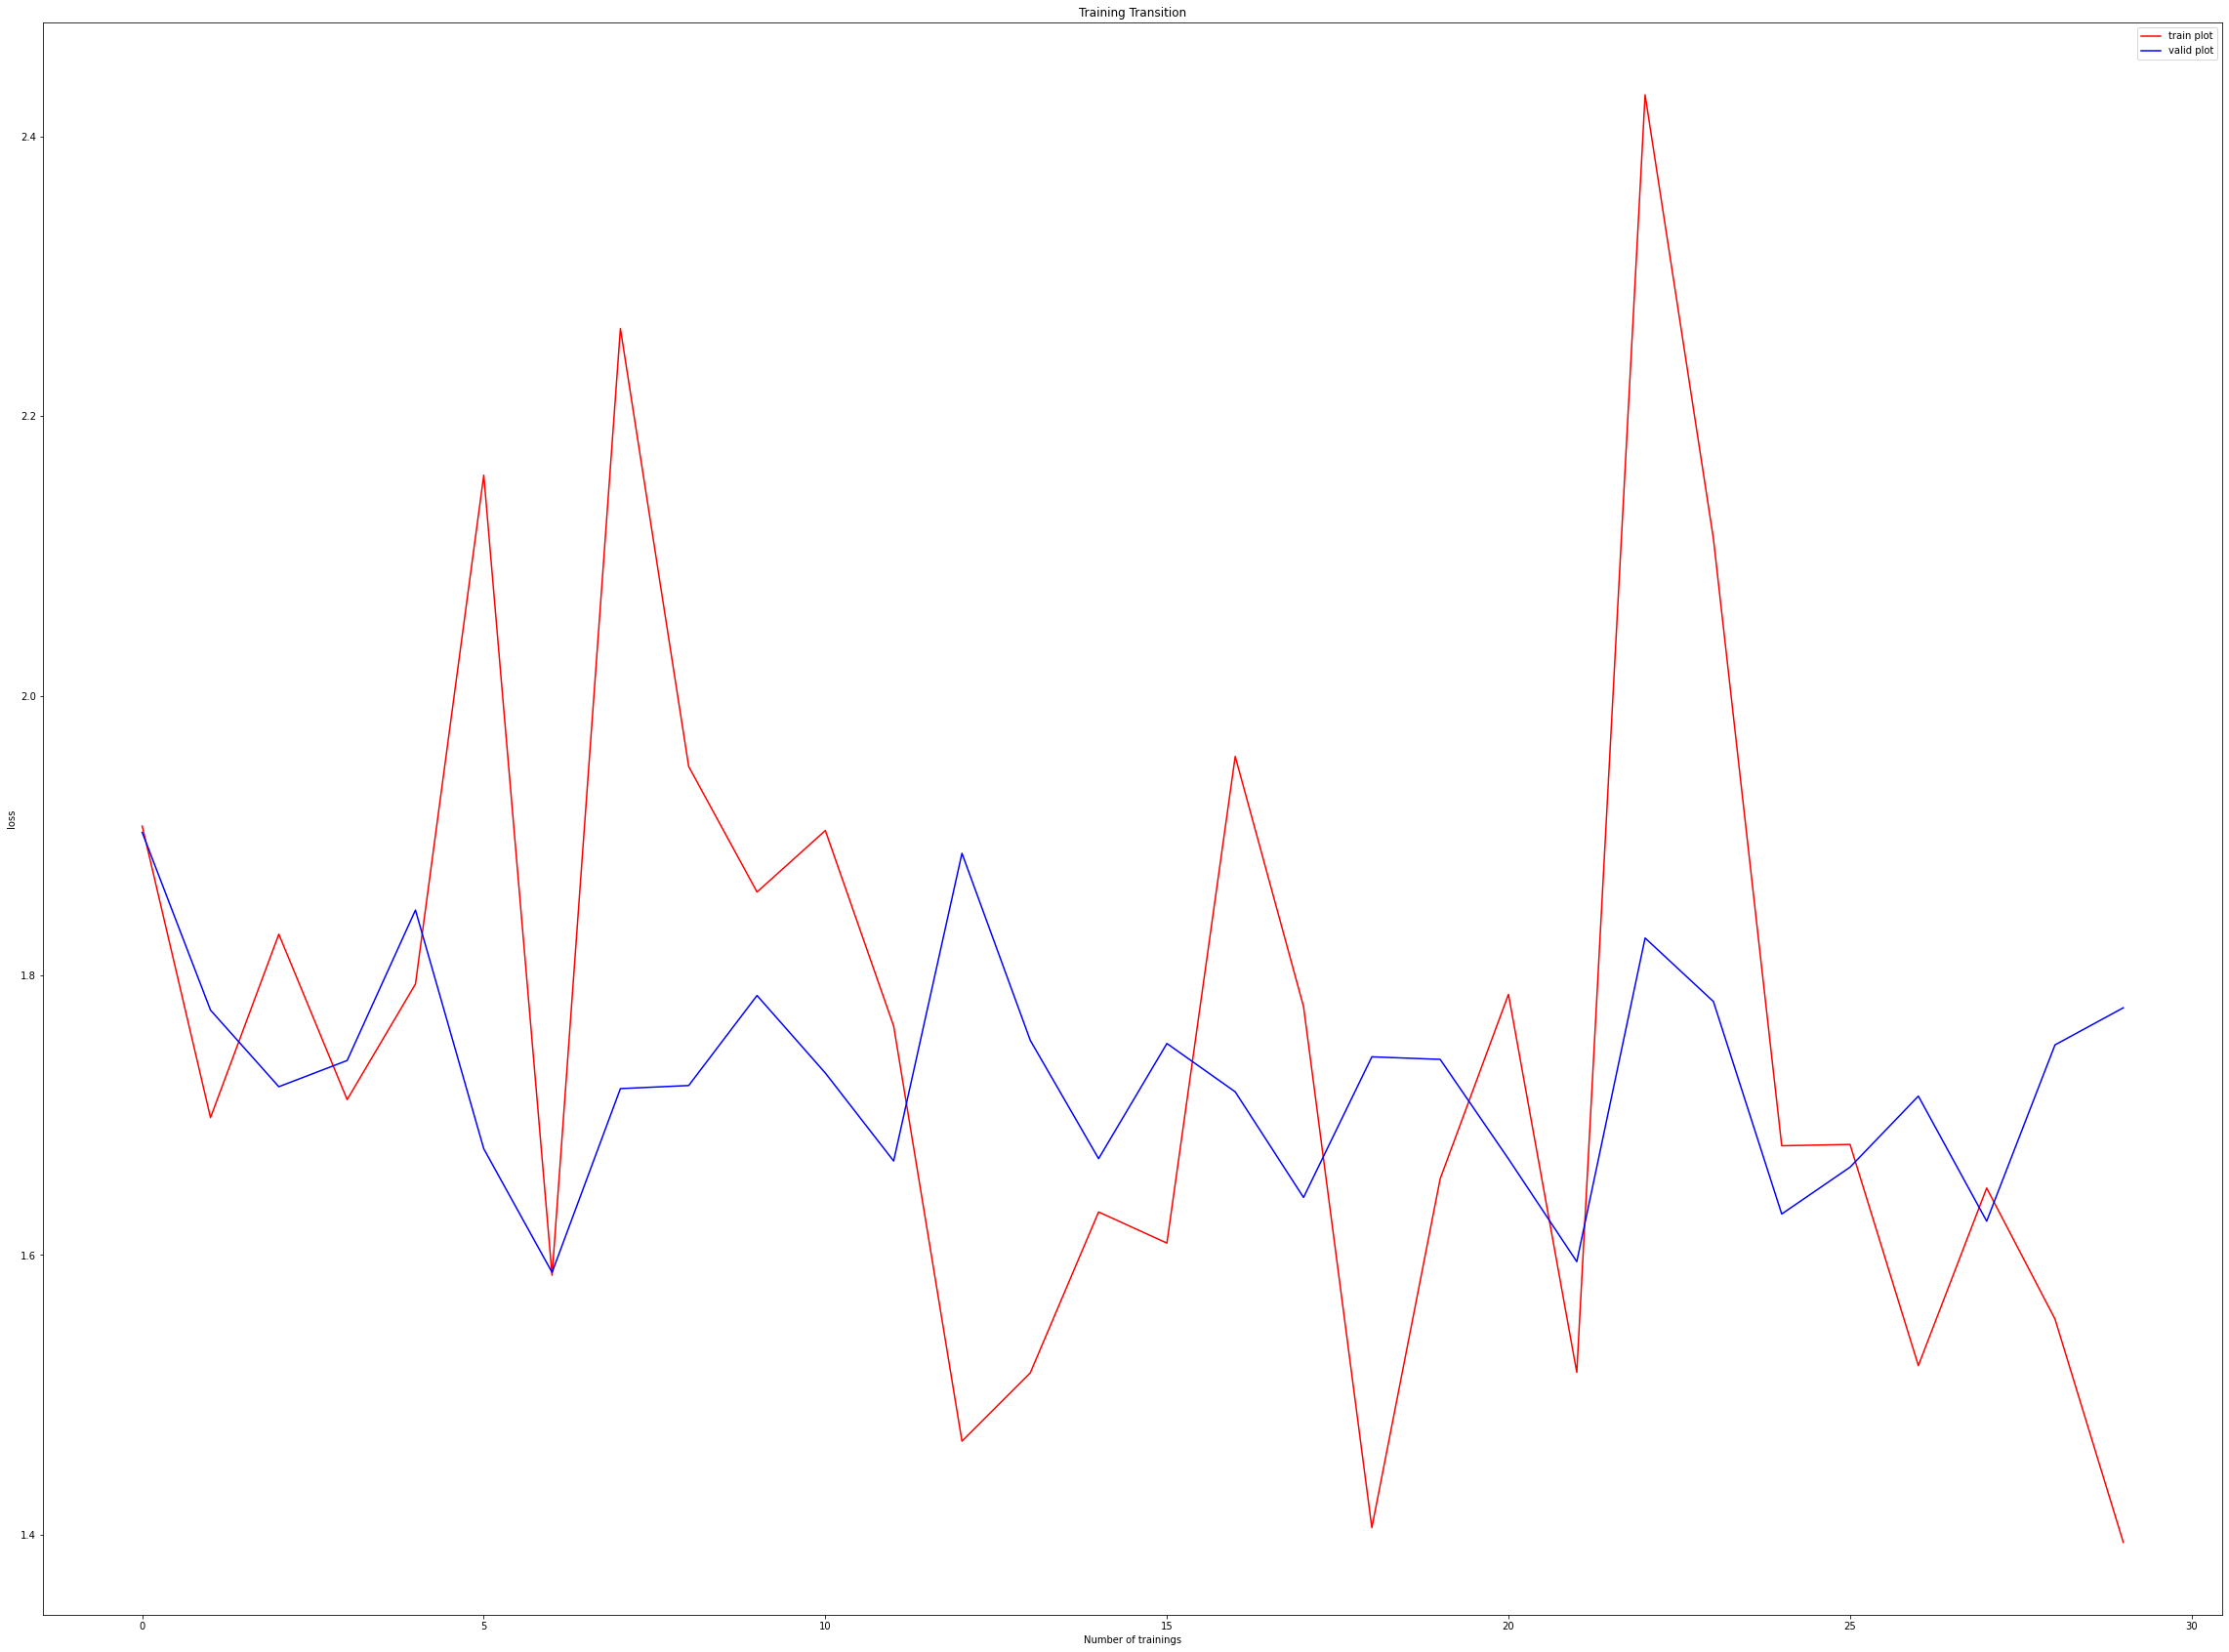

In [37]:
plots(plot_train_losses, plot_valid_losses)

### モデル評価

In [ ]:
_, _, _, _, XDA_test, YDA_test, _, _, DAturn = create_DAdata(config, model_name+loss_name)
_, _, _, _, XUtt_test, YUtt_test = create_Uttdata(config, model_name+loss_name)

XDA_test, YDA_test = DA_vocab.tokenize(XDA_test, YDA_test)
XUtt_test, _ = Utt_vocab.tokenize(XUtt_test, YUtt_test)

print('tokenizer finish')

tokenizer finish


In [39]:
models.load_state_dict(
    torch.load(
        os.path.join(
            config[model_name+loss_name]['log_dir'], 
            config[model_name+loss_name]['SAVE_NAME'] + "_" + str(config[model_name+loss_name]['window_size']) + "_" + reductions + "_Paramater" + str(Pramater_N) + "_Epochs" + str(config[model_name+loss_name]['EPOCH']) + ".model".format('model_save')
        )
    )
)
print('{} model loaded'.format(model_name+loss_name))

CmbAttentionCE_weight model loaded


In [46]:
loss_name = "FL"
Pramater_N = 2

models.load_state_dict(
    torch.load(
        os.path.join(
            config[model_name+loss_name]['log_dir'], 
            config[model_name+loss_name]['SAVE_NAME'] + "_" + str(config[model_name+loss_name]['window_size']) + "_" + reductions + "_Paramater" + str(Pramater_N) + "_Epochs" + str(config[model_name+loss_name]['EPOCH']) + "_V2.model".format('model_save')
        )
    )
)
print('{} model loaded'.format(model_name+loss_name))

CmbAttentionFL model loaded


## テスト

In [39]:
@torch.no_grad()

def ModelTest(models):
    result=[]
    for seq_idx in range(0, len(XDA_test)):
        print('\r{}/{} conversation evaluating'.format(seq_idx+1, len(XDA_test)), end='')
        XDA_seq = XDA_test[seq_idx]
        YDA_seq = YDA_test[seq_idx]
        DAturn[seq_idx] = DAturn[seq_idx] + [0] * (len(XDA_seq) - len(DAturn[seq_idx]))
        DAturn_seq = DAturn[seq_idx]
        XUtt_seq = XUtt_test[seq_idx]

        pred_seq = []
        true_seq = []
        utter_hidden, context_hidden, da_hidden = models.initDAHidden(1)

        for i in range(0, len(XDA_seq)):
            XDA_tensor = torch.tensor([[XDA_seq[i]]]).to(device)
            YDA_tensor = torch.tensor(YDA_seq[i]).to(device)
            DAturn_tensor = torch.tensor([[DAturn_seq[i]]]).to(device)
            DAturn_tensor = DAturn_tensor.float()
            DAturn_tensor = DAturn_tensor.unsqueeze(1)
            XUtt_tensor = torch.tensor([XUtt_seq[i]]).to(device)

            output, utter_hidden, context_hidden, da_hidden, att_weights = models.prediction(XUtt_tensor, XDA_tensor, None, utter_hidden, context_hidden, da_hidden, DAturn_tensor)
            
            pred_idx = torch.argmax(output)
            pred_seq.append(pred_idx.item())
            true_seq.append(YDA_tensor.item())
            utter_list = [Utt_vocab.id2word[word] for word in XUtt_seq[i]]

        result.append({'true': true_seq,
                        'true_detok': [DA_vocab.id2word[token] for token in true_seq],
                        'pred': pred_seq,
                        'pred_detok': [DA_vocab.id2word[token] for token in pred_seq],
                        'UttSeq': [[Utt_vocab.id2word[word] for word in sentence] for sentence in XUtt_seq],
                        'seq_detok': [DA_vocab.id2word[label] for label in XDA_seq]})
    return result

In [40]:
def calc_average(y_true, y_pred):
    p = precision_score(y_true=y_true, y_pred=y_pred, average='macro')
    r = recall_score(y_true=y_true, y_pred=y_pred, average='macro')
    f = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    acc = accuracy_score(y_true=y_true, y_pred=y_pred)
    print('p: {} | r: {} | f: {} | acc: {}'.format(p*100, r*100, f*100, acc*100))

In [41]:
def Evelu(result, loss_name):
    true = [label for line in result for label in line['true']]
    pred = [label for line in result for label in line['pred']]

    calc_average(y_true=true, y_pred=pred)
    f = f1_score(y_true=true, y_pred=pred, average=None)
    r = recall_score(y_true=true, y_pred=pred, average=None)
    p = precision_score(y_true=true, y_pred=pred, average=None)
    
    
    print("Recall")
    [print(DA_vocab.id2word[idx], score*100) for idx, score in zip(sorted(set(true)),r)]
    print("F-Score")
    [print(DA_vocab.id2word[idx], score*100) for idx, score in zip(sorted(set(true)),f)]
    
#     save_cmx(true, pred, loss_name, num)

In [47]:
result=ModelTest(models)
Evelu(result, loss_name)

19281/19281 conversation evaluatingp: 41.56598652692674 | r: 29.425931704372267 | f: 28.93511745523285 | acc: 65.26010061718792
Recall
<Statement> 84.58922498657599
<Understanding> 78.57387287193087
<Uninterpretable> 0.2863766534842493
<Agreement> 12.198414037455711
<Question> 5.502200880352141
<Other> 0.47343503419253025
<Apology> 2.1447721179624666
<Greeting> 81.06508875739645
<Directive> 0.0
F-Score
<Statement> 77.5432071756727
<Understanding> 66.04703005896737
<Uninterpretable> 0.5668016194331984
<Agreement> 16.36672325976231
<Question> 9.900990099009901
<Other> 0.9311950336264873
<Apology> 3.9669421487603307
<Greeting> 85.09316770186335
<Directive> 0.0


In [43]:
loss_name, reductions, Pramater_N, str(config[model_name+loss_name]['EPOCH'])

('CE', 'mean', 1, '30')

In [46]:
CE, mean

p:41.8%  r:29.7%  f:28.7%  acc:66.5%

<Statement>       78.8%
<Understanding>   67.2%
<Uninterpretable>  0.0%
<Agreement>       15.4%
<Question>        11.3%
<Other>            0.8%
<Apology>          1.1%
<Greeting>        82.2%
<Directive>        1.8%

p: 33.78118527495406 | r: 29.42954038000246 | f: 27.785147327497345 | acc: 65.7092474456719

F-Score
<Statement>       78.02561493257058
<Understanding>   66.01580986100644
<Uninterpretable>  0.0
<Agreement>       17.91006642820644
<Question>        10.311111111111111
<Other>            0.0
<Apology>          2.0425531914893616
<Greeting>        75.76117042309214
<Directive>        0.0

p: 50.23199236152334 | r: 29.81734783491634 | f: 29.127128936070656 | acc: 66.36066594056325

F-Score
<Statement>       78.73011149650818
<Understanding>   66.83718973496003
<Uninterpretable>  0.0
<Agreement>       12.979106129791063
<Question>        12.026097690001764
<Other>            0.10515247108307045
<Apology>          1.2195121951219513
<Greeting>        85.23131672597865
<Directive>        5.0156739811912224

p: 41.38782576078607 | r: 29.92178789263492 | f: 29.314838155567436 | acc: 67.56910948602251

F-Score
<Statement>       79.626051843645
<Understanding>   68.63462238477406
<Uninterpretable>  0.0
<Agreement>       15.352697095435689
<Question>        11.444521981856246
<Other>            2.3541453428863868
<Apology>          0.17761989342806392
<Greeting>        85.58599012123933
<Directive>        0.6578947368421052

SyntaxError: invalid syntax (849736833.py, line 3)

In [ ]:
FL, mean p=2

p:36.5%  r:28.1%  f:26.8%  acc:62.8%

<Statement>       75.4%
<Understanding>   63.0%
<Uninterpretable>  0.2%
<Agreement>        9.4%
<Question>         8.1%
<Other>            1.0%
<Apology>          1.2%
<Greeting>        83.6%
<Directive>        0.0%

p: 34.57094921887097 | r: 27.183821784425966 | f: 25.42952909645296 | acc: 59.57574814584305

F-Score
<Statement>       72.30599771905369
<Understanding>   59.44633623407742
<Uninterpretable>  0.0
<Agreement>        7.7300466674644
<Question>         7.891356212149019
<Other>            0.2099737532808399
<Apology>          0.0
<Greeting>        81.28205128205128
<Directive>        0.0

p: 42.43928329810369 | r: 29.414178019250414 | f: 28.94133017367314 | acc: 65.21238524972771

F-Score
<Statement>       77.53148981935506
<Understanding>   65.89580823248036
<Uninterpretable>  0.67394527564361775
<Agreement>       16.12939712702183
<Question>        10.106478974914275
<Other>            1.3408973697782363
<Apology>          3.485477178423236
<Greeting>        85.30847758544163
<Directive>        0.0

p: 32.59599376787789 | r: 27.774415249331124 | f: 25.991758563531587 | acc: 63.58280172190239

F-Score
<Statement>       76.24196104017149
<Understanding>   62.796461338979434
<Uninterpretable>  0.0
<Agreement>        4.3181457374186385
<Question>         6.409539780137881
<Other>            0.0
<Apology>          0.0
<Greeting>        84.1597191750768
<Directive>        0.0

In [ ]:
LogAll, mean

p:36.9%  r:37.4%  f:35.5%  acc:61.7%

<Statement>       75.2%
<Understanding>   66.2%
<Uninterpretable>  2.5%
<Agreement>       27.7%
<Question>        17.2%
<Other>           11.5%
<Apology>         25.4%
<Greeting>        83.7%
<Directive>       10.1%

p: 36.76124218201459 | r: 37.694062457478184 | f: 35.03261507146851 | acc: 61.54660028006846

F-Score
<Statement>       75.53506817392015
<Understanding>   66.33980351621815
<Uninterpretable>  0.7490636704119851
<Agreement>       25.16745224510047
<Question>        16.249623153451914
<Other>           11.672131147540984
<Apology>         24.43841026906937
<Greeting>        84.94242692648362
<Directive>       10.199556541019955


p: 37.90773506455931 | r: 37.02271796185407 | f: 36.02583577269132 | acc: 62.60567397956538

F-Score
<Statement>       75.9861648686486
<Understanding>   66.14243374278322
<Uninterpretable>  3.527462121212121
<Agreement>       28.69524109675386
<Question>        17.564049869845183
<Other>           11.48936170212766
<Apology>         24.965132496513248
<Greeting>        84.59507042253521
<Directive>       11.267605633802816

p: 35.9939481565746 | r: 37.56256500366494 | f: 35.4678890166005 | acc: 60.90762927234065

F-Score
<Statement>       74.0130888954147
<Understanding>   66.19012092926418
<Uninterpretable>  3.267267267267267
<Agreement>       29.181775185243573
<Question>        17.67312318014939
<Other>           11.413148255253516
<Apology>         26.92702980472765
<Greeting>        81.55668358714044
<Directive>        8.98876404494382

In [ ]:
CE_weight, mean

p=1

p:39.3%  r:37.2%  f:35.0%  acc:63.4%

<Statement>       76.6%
<Understanding>   66.6%
<Uninterpretable>  0.8%
<Agreement>       28.7%
<Question>        15.3%
<Other>            8.4%
<Apology>         26.6%
<Greeting>        83.5%
<Directive>        8.4%

p: 41.92093487212905 | r: 37.34742084485293 | f: 35.290224026758793 | acc: 64.72278408796224

F-Score
<Statement>       77.90332402207637
<Understanding>   66.46637225801783
<Uninterpretable>  0.08169934640522875
<Agreement>       28.563848602759107
<Question>        16.012223071046602
<Other>            7.540394973070018
<Apology>         26.47496281606346
<Greeting>        84.48961555457357
<Directive>       10.079575596816977

p: 37.37756277063593 | r: 37.007597583473756 | f: 34.42205192114174 | acc: 61.08293138322701

F-Score
<Statement>       74.25056403719106
<Understanding>   67.13289294017788
<Uninterpretable>  1.1143539400371452
<Agreement>       28.75457875457875
<Question>        14.358251057827925
<Other>            8.018661612479953
<Apology>         26.245847176079734
<Greeting>        82.96679603277274
<Directive>        6.956521739130435

p: 38.70584105658027 | r: 37.13643835519591 | f: 35.29512466256214 | acc: 64.33068824231108

F-Score
<Statement>       77.6356418173798
<Understanding>   66.22610779339911
<Uninterpretable>  1.1945845500398196
<Agreement>       28.843945950719775
<Question>        15.65670414038936
<Other>            9.542586750788644
<Apology>         27.167161760734537
<Greeting>        83.11688311688312
<Directive>        8.27250608272506


p=2

p:36.8%  r:31.7%  f:31.0%  acc:62.1%

<Statement>       74.9%
<Understanding>   64.0%
<Uninterpretable>  0.0%
<Agreement>       24.4%
<Question>        13.3%
<Other>            4.9%
<Apology>         12.0%
<Greeting>        82.8%
<Directive>        2.4%

p: 39.85314323623631 | r: 34.67831513738398 | f: 34.47528347302799 | acc: 65.28292101032103

F-Score
<Statement> 　　　　　　　　　　　　78.47351787686098
<Understanding> 　　　　66.28334190609155
<Uninterpretable> 　　0.0
<Agreement> 　　　　　　　　　　　　30.804597701149422
<Question> 　　　　　　　　　　　　　　13.183545349413514
<Other> 　　　　　　　　　　　　　　　　　　　　　　9.484873262469337
<Apology> 　　　　　　　　　　　　　　　　22.203171881697383
<Greeting> 　　　　　　　　　　　　　　85.34289556252801
<Directive> 　　　　　　　　　　　　　　4.5016077170418

p: 40.73699059202 | r: 31.979720361175207 | f: 32.235807740368685 | acc: 65.76526113790779

F-Score
<Statement> 　　　　　　　　　　　　78.33612348551485
<Understanding> 　　　　66.74335912988914
<Uninterpretable> 　　0.0
<Agreement> 　　　　　　　　　　　　25.189469485440767
<Question> 　　　　　　　　　　　　　　15.573505654281098
<Other> 　　　　　　　　　　　　　　　　　　　　　　5.074198180947821
<Apology> 　　　　　　　　　　　　　　　　11.096605744125327
<Greeting> 　　　　　　　　　　　　　85.43342269883824
<Directive>　　　　　　　　　　　　　 2.6755852842809364

p: 29.91486584404529 | r: 28.355620939959376 | f: 26.174401676789994 | acc: 55.32285669830404

F-Score
<Statement>       68.02992206491462
<Understanding>   58.984906340648
<Uninterpretable>  0.0
<Agreement>       17.07142857142857
<Question>        11.074918566775246
<Other>            0.10482180293501049
<Apology>          2.745995423340961
<Greeting>        77.55762232106753
<Directive>        0.0


p=3

p:40.7%  r:35.2%  f:34.1%  acc:63.9%

<Statement>       77.1%
<Understanding>   65.3%
<Uninterpretable>  0.0%
<Agreement>       25.2%
<Question>        15.1%
<Other>            6.9%
<Apology>         24.5%
<Greeting>        84.6%
<Directive>        7.8%

p: 44.038515087103825 | r: 35.01685435093073 | f: 34.09339503378885 | acc: 64.81614024168871

F-Score
<Statement> 　　　　　　　　　　　78.0474404152931
<Understanding> 　　　65.82830315224682
<Uninterpretable>　 0.027266530334014993
<Agreement> 　　　　　　　　　　　28.571428571428577
<Question> 　　　　　　　　　　　　　14.571709878569084
<Other> 　　　　　　　　　　　　　　　　　　　　　6.082614616432138
<Apology> 　　　　　　　　　　　　　　　25.4505332842957
<Greeting> 　　　　　　　　　　　　　83.44198174706649
<Directive> 　　　　　　　　　　　　　4.8192771084337345

p: 39.51348040697679 | r: 35.05895908296361 | f: 34.20297115921588 | acc: 64.39500025932266

F-Score
<Statement>       77.51067132324408
<Understanding>   65.93229822352778
<Uninterpretable>  0.0
<Agreement>       24.95137046861185
<Question>        15.39484621778886
<Other>            7.103825136612022
<Apology>         22.86275794300688
<Greeting>        84.98006202924235
<Directive>        9.090909090909092

p: 38.60217921190662 | r: 35.59127822090275 | f: 33.88534434159951 | acc: 62.527877184793326

F-Score
<Statement>       75.72243624128345
<Understanding>   64.06335239771226
<Uninterpretable>  0.0
<Agreement>       22.01964775643862
<Question>        15.422968256606282
<Other>            7.610993657505285
<Apology>         25.338894681960376
<Greeting>        85.31905399375279
<Directive>        9.47075208913649

p=4

p:34.5%  r:38.1%  f:34.3%  acc:59.3%

<Statement>       73.8%
<Understanding>   64.5%
<Uninterpretable>  0.0%
<Agreement>       26.7%
<Question>        17.6%
<Other>            8.3%
<Apology>         26.4%
<Greeting>        82.9%
<Directive>        8.8%


p: 34.154186086357555 | r: 38.29161087880891 | f: 35.18869877006995 | acc: 61.01550749442456

F-Score
<Statement>       75.16250944822373
<Understanding>   65.80349447622032
<Uninterpretable>  0.0
<Agreement>       30.81425891181989
<Question>        19.909306845173827
<Other>            9.338138925294889
<Apology>         25.861155272919977
<Greeting>        83.17677198975235
<Directive>        6.63265306122449

p: 35.654965663408845 | r: 39.74731736775568 | f: 36.199479171508685 | acc: 61.590166485140806

F-Score
<Statement>       76.32562199056593
<Understanding>   64.56546833773086
<Uninterpretable>  0.0
<Agreement>       29.635189911424714
<Question>        17.73598171910705
<Other>           10.23728813559322
<Apology>         29.242032730404826
<Greeting>        85.19341929746554
<Directive>       12.86031042128603

p: 33.74873936999551 | r: 36.24038337254866 | f: 31.606642115617877 | acc: 55.44525698874539

F-Score
<Statement> 　　　　　　　　　　　　69.81487757349826
<Understanding> 　　　　63.00139262106976
<Uninterpretable> 　　0.0
<Agreement> 　　　　　　　　　　　　19.617644479522934
<Question> 　　　　　　　　　　　　　　15.280088740987244
<Other> 　　　　　　　　　　　　　　　　　　　　　　5.3739364084191665
<Apology> 　　　　　　　　　　　　　　　　24.026740070782544
<Greeting>　　 　　　　　　　　　　　　80.36835496023443
<Directive> 　　　　　　　　　　　　　　6.976744186046512

p=5

p:34.8%  r:38.6%  f:34.7%  acc:59.5%

<Statement>       72.8%
<Understanding>   65.4%
<Uninterpretable>  0.6%
<Agreement>       28.7%
<Question>        17.8%
<Other>           10.2%
<Apology>         27.3%
<Greeting>        81.5%
<Directive>        8.0%


p: 35.4558185709027 | r: 38.14061008345092 | f: 35.014949300396374 | acc: 61.789326279757276

F-Score
<Statement>       75.45391170441894
<Understanding>   65.81384479565165
<Uninterpretable>  1.6266460108443066
<Agreement>       29.958479718939635
<Question>        16.07164468110856
<Other>           10.872519706441967
<Apology>         26.543209876543205
<Greeting>        81.57560355781449
<Directive>        7.218683651804671

p: 34.55051862306105 | r: 39.402982406049745 | f: 34.99181705502894 | acc: 59.83921995747109

F-Score
<Statement>       73.24428942107278
<Understanding>   65.74847115128955
<Uninterpretable>  0.1626898047722343
<Agreement>       30.202083991158823
<Question>        19.293015332197616
<Other>           11.038536903984324
<Apology>         28.50418410041841
<Greeting>        77.72020725388602
<Directive>        9.012875536480687

p: 34.317878998451725 | r: 38.22741325820233 | f: 34.10199868628392 | acc: 56.99393185000778

F-Score
<Statement>       69.63046208765783
<Understanding>   64.55165889587133
<Uninterpretable>  0.0
<Agreement>       25.96883739512585
<Question>        18.078648719978887
<Other>            8.84934756820878
<Apology>         26.897347174163784
<Greeting>        85.1177254553532
<Directive>        7.823960880195598


p=6

p:34.8%  r:38.7%  f:35.0%  acc:61.5%

<Statement>       75.4%
<Understanding>   65.4%
<Uninterpretable>  0.1%
<Agreement>       25.2%
<Question>        18.4%
<Other>            9.8%
<Apology>         27.4%
<Greeting>        82.7%
<Directive>       10.3%

p: 34.781026727711617 | r: 38.476636648688367 | f: 34.851490616027636 | acc: 63.3131061666926

F-Score
<Statement>       77.27688236709166
<Understanding>   65.19294902334445
<Uninterpretable>  0.0
<Agreement>       23.240749828246146
<Question>        18.565400843881857
<Other>            9.608785175017158
<Apology>         28.71085807238715
<Greeting>        83.13827481577806
<Directive>        7.929515418502202

p: 34.26292137870048 | r: 37.573762317373 | f: 34.51031638374991 | acc: 59.335096727348166

F-Score
<Statement>       72.89259251657396
<Understanding>   65.30711519392318
<Uninterpretable>  0.3227107704719645
<Agreement>       27.036737626875055
<Question>        18.70139968895801
<Other>            8.98876404494382
<Apology>         26.647398843930638
<Greeting>        80.8848080133556
<Directive>        9.811320754716983

p: 35.355934371378495 | r: 40.141899992105984 | f: 35.54790538654732 | acc: 61.87542139930502

F-Score
<Statement>       76.05807478122514
<Understanding>   65.83570933189489
<Uninterpretable>  0.0
<Agreement>       25.26148969889065
<Question>        17.899343544857768
<Other>           10.755064456721916
<Apology>         26.784171418697085
<Greeting>        84.14580588493634
<Directive>       13.191489361702127


p=7

p:36.9%  r:39.3%  f:35.1%  acc:62.5%

<Statement>       76.5%
<Understanding>   66.0%
<Uninterpretable>  0.1%
<Agreement>       27.8%
<Question>        18.8%
<Other>           11.1%
<Apology>         28.6%
<Greeting>        79.0%
<Directive>        7.6%

p: 37.25061663071679 | r: 38.666678728757065 | f: 34.962761968347306 | acc: 62.56107048389606

F-Score
<Statement>       76.30285152409045
<Understanding>   66.45489915982182
<Uninterpretable>  0.02726281352235551
<Agreement>       27.653377025304937
<Question>        18.990718019844235
<Other>           11.871030776746458
<Apology>         27.62691853600944
<Greeting>        78.19063004846527
<Directive>        7.547169811320753

p: 38.49250281742454 | r: 39.62843701677192 | f: 34.74303877477416 | acc: 61.556973186038064

F-Score
<Statement>       75.80579604113319
<Understanding>   65.51634084465005
<Uninterpretable>  0.3532128786849613
<Agreement>       28.32731436624681
<Question>        17.96050852042196
<Other>           10.395554102647923
<Apology>         28.83204441800516
<Greeting>        78.43775427176567
<Directive>        7.0588235294117645

p: 34.98353593134074 | r: 39.51045306545033 | f: 35.48378035879847 | acc: 63.3131061666926

F-Score
<Statement>       77.42601648191079
<Understanding>   66.01488853038931
<Uninterpretable>  0.0
<Agreement>       27.38677818311238
<Question>        19.31530008453085
<Other>           11.04862719153159
<Apology>         29.445585215605753
<Greeting>        80.46940486169322
<Directive>        8.24742268041237

In [ ]:
CE_matrix, mean

P=1

p:40.2%  r:33.0%  f:32.5%  acc:64.9%

<Statement>       77.6%
<Understanding>   65.4%
<Uninterpretable>  0.1%
<Agreement>       21.4%
<Question>        11.6%
<Other>            7.6%
<Apology>         21.1%
<Greeting>        83.3%
<Directive>        4.4%

p: 38.913342429516373 | r: 31.910863066317713 | f: 31.62360522262686 | acc: 63.79233442248846

F-Score
<Statement>       76.75796952416566
<Understanding>   63.70594017694143
<Uninterpretable>  0.0
<Agreement>       18.081871345029238
<Question>         7.552703941338222
<Other>           10.569438754608766
<Apology>         18.945699564011095
<Greeting>        84.06055209260908
<Directive>        4.938271604938271

p: 39.22994410394349 | r: 32.16764910636975 | f: 31.61572954218675 | acc: 64.7186349255744

F-Score
<Statement>       77.54837515044903
<Understanding>   64.88029400221215
<Uninterpretable>  0.0
<Agreement>       17.17849158724556
<Question>        11.337311337311338
<Other>            5.291005291005291
<Apology>         20.363636363636367
<Greeting>        82.6012058570198
<Directive>        5.341246290801187

p: 42.49217316971618 | r: 34.9927770502853 | f: 34.29218126572806 | acc: 66.24034023131581

F-Score
<Statement>       78.64855649011139
<Understanding>   67.72701394819242
<Uninterpretable>  0.3796095444685466
<Agreement>       28.999388628489907
<Question>        15.933183424349503
<Other>            6.804597701149424
<Apology>         24.0981240981241
<Greeting>        83.18201469952442
<Directive>        2.857142857142857


p=2

p:36.4%  r:36.8%  f:34.4%  acc:62.8%

<Statement>       76.3%
<Understanding>   65.7%
<Uninterpretable>  2.1%
<Agreement>       27.8%
<Question>        15.2%
<Other>           10.8%
<Apology>         24.8%
<Greeting>        81.5%
<Directive>        5.1%

p: 35.8301859990609 | r: 36.226339528609905 | f: 33.86343300693748 | acc: 61.962553809449716

F-Score
<Statement>       75.44653536400607
<Understanding>   65.85263465294129
<Uninterpretable>  2.146511918133034
<Agreement>       27.441782543139553
<Question>        14.695612570214056
<Other>           10.217437196537894
<Apology>         22.966765738989462
<Greeting>        81.36593591905564
<Directive>        4.63768115942029

p: 36.577214532193395 | r: 37.03235010472612 | f: 34.56523378864327 | acc: 63.55790674757533

F-Score
<Statement>       77.15748964463725
<Understanding>   65.7745678514472
<Uninterpretable>  1.7126306510515044
<Agreement>       28.24582137430356
<Question>        16.333777185974256
<Other>           11.510791366906474
<Apology>         25.524296675191817
<Greeting>        80.28227480282276
<Directive>        4.545454545454546

p: 36.65966766809374 | r: 37.13436126112397 | f: 34.727539741169245 | acc: 62.783050671645654

F-Score
<Statement>       76.25843434645012
<Understanding>   65.52610900778627
<Uninterpretable>  2.5
<Agreement>       27.811009969657558
<Question>        14.498194945848375
<Other>           10.81267217630854
<Apology>         26.019417475728158
<Greeting>        82.92046936114733
<Directive>        6.2015503875969


p=3

p:34.4%  r:38.0%  f:34.6%  acc:58.9%

<Statement>       73.0%
<Understanding>   65.3%
<Uninterpretable>  4.7%
<Agreement>       29.2%
<Question>        16.3%
<Other>           10.1%
<Apology>         24.8%
<Greeting>        82.0%
<Directive>        5.7%

p: 34.27929313329877 | r: 36.09048100147623 | f: 34.28385199283474 | acc: 58.44821326694674

F-Score
<Statement>       72.13484092392565
<Understanding>   65.91269619095608
<Uninterpretable>  6.162687010799565
<Agreement>       28.478862109838005
<Question>        16.359871145881268
<Other>            8.183118741058655
<Apology>         23.18840579710145
<Greeting>        81.12484022155944
<Directive>        7.009345794392523

p: 34.74132518125368 | r: 40.82131346206691 | f: 35.67332407864849 | acc: 59.70748405165707

F-Score
<Statement>       74.26499947462436
<Understanding>   65.50291262135923
<Uninterpretable>  5.956920540039163
<Agreement>       32.415691672401934
<Question>        18.139873725109275
<Other>           12.358674463937623
<Apology>         26.876019575856446
<Greeting>        81.30287648054146
<Directive>        4.241948153967007

p: 34.12831874800839 | r: 37.06375405925924 | f: 33.75473980974627 | acc: 58.60899330947566

F-Score
<Statement>       72.53978835097075
<Understanding>   64.50502470712343
<Uninterpretable>  1.8426103646833016
<Agreement>       26.825656612890658
<Question>        14.543579164517793
<Other>            9.64735976612461
<Apology>         24.42244224422442
<Greeting>        83.71080139372822
<Directive>        5.755395683453238



p=4

p:32.0%  r:37.2%  f:31.5%  acc:48.3%

<Statement>       61.0%
<Understanding>   60.8%
<Uninterpretable> 10.0%
<Agreement>       25.1%
<Question>        13.7%
<Other>            8.4%
<Apology>         23.5%
<Greeting>        74.7%
<Directive>        6.2%

p: 30.41399187733224 | r: 39.85306717951647 | f: 31.80582328333379 | acc: 50.74633058451325

F-Score
<Statement>       66.56664108760637
<Understanding>   59.04778296508252
<Uninterpretable>  5.700397702165268
<Agreement>       29.454470026965364
<Question>        16.129559954195976
<Other>            8.3562621012942
<Apology>         25.40551104162595
<Greeting>        67.24557137895103
<Directive>        8.346213292117465

p: 32.47316446159935 | r: 39.84150678717565 | f: 33.68826334476845 | acc: 52.23587988174887

F-Score
<Statement>       64.96442413374213
<Understanding>   65.1685393258427
<Uninterpretable> 10.07899356348742
<Agreement>       28.043188877385006
<Question>        15.384615384615383
<Other>            8.825342043633674
<Apology>         26.50258605314785
<Greeting>        77.05179282868527
<Directive>        7.174887892376682

p: 33.02240270328935 | r: 31.860574969899236 | f: 28.973155670567607 | acc: 42.06317099735491

F-Score
<Statement>       51.124738970685414
<Understanding>   58.25950245075372
<Uninterpretable> 14.20012395840507
<Agreement>       17.925179092597503
<Question>         9.709039987552512
<Other>            8.003300330033003
<Apology>         18.648275862068964
<Greeting>        79.73366625052019
<Directive>        3.154574132492114


p=5

p:34.2%  r:33.5%  f:29.7%  acc:38.2%

<Statement>       42.2%
<Understanding>   59.5%
<Uninterpretable> 15.1%
<Agreement>       20.8%
<Question>        12.1%
<Other>            8.6%
<Apology>         20.8%
<Greeting>        82.0%
<Directive>        6.5%

p: 34.611108508172194 | r: 33.72716923817643 | f: 30.139105752039946 | acc: 42.92827135522017

F-Score
<Statement>       50.623253103018904
<Understanding>   62.226043756568274
<Uninterpretable> 14.897940045637837
<Agreement>       22.49681991640923
<Question>         7.349882124531966
<Other>            6.658130601792574
<Apology>         21.84643510054844
<Greeting>        82.50444049733571
<Directive>        2.6490066225165565

p: 34.06625509862265 | r: 35.23442770620371 | f: 31.12077968092462 | acc: 39.770758778071674

F-Score
<Statement>       45.05992461779528
<Understanding>   60.70058808488877
<Uninterpretable> 15.087426073540753
<Agreement>       23.132369086829918
<Question>        15.47215824414036
<Other>            9.895298706631081
<Apology>         21.44566778362853
<Greeting>        80.87774294670847
<Directive>        8.415841584158414

p: 33.84653441196401 | r: 31.612700214002988 | f: 27.943007956440052 | acc: 31.95788600176339

F-Score
<Statement>       31.006102331403536
<Understanding>   55.627675735395655
<Uninterpretable> 15.29679753450355
<Agreement>       16.85221039044853
<Question>        13.383015059773326
<Other>            9.276546091015167
<Apology>         19.154160982264663
<Greeting>        82.57887517146776
<Directive>        8.311688311688311

In [ ]:
CE_matrix_v2, mean

p:40.3%  r:30.3%  f:29.8%  acc:66.0%

<Statement>       78.3%
<Understanding>   66.7%
<Uninterpretable>  1.1%
<Agreement>       17.6%
<Question>         9.0%
<Other>            4.9%
<Apology>          6.5%
<Greeting>        81.6%
<Directive>        2.8%

p: 34.163070521488426 | r: 29.47670049180792 | f: 27.845997081955237 | acc: 65.81297650536798

F-Score
<Statement>       78.13528101831912
<Understanding>   66.09253867471147
<Uninterpretable>  0.0
<Agreement>       18.188775510204083
<Question>        10.374844554983123
<Other>            0.0
<Apology>          1.7226528854435832
<Greeting>        76.0998810939358
<Directive>        0.0


p: 43.74410490489379 | r: 30.67346049216105 | f: 30.797630080982135 | acc: 66.03288211192366

F-Score
<Statement>       78.31438775795668
<Understanding>   66.97740881872618
<Uninterpretable>  0.9083622762489982
<Agreement>       14.864682913693281
<Question>        10.256410256410257
<Other>            8.425531914893618
<Apology>          8.739255014326647
<Greeting>        84.23403305046895
<Directive>        4.4585987261146505

p: 42.949215868510876 | r: 30.746824156717732 | f: 30.85096988864163 | acc: 66.12312639385924

F-Score
<Statement>       78.52530955641892
<Understanding>   67.08518013900627
<Uninterpretable>  2.2806790203446936
<Agreement>       19.703235222573586
<Question>         6.38220277169949
<Other>            6.133828996282528
<Apology>          9.070958302852963
<Greeting>        84.61881408827465
<Directive>        3.858520900321543

## 分散表現の可視化

In [61]:
@torch.no_grad()

def ModelTestTSNE(models):
    result=[]
    for seq_idx in range(0, len(XDA_test)):
        print('\r{}/{} conversation evaluating'.format(seq_idx+1, len(XDA_test)), end='')
        XDA_seq = XDA_test[seq_idx]
        YDA_seq = YDA_test[seq_idx]
        DAturn[seq_idx] = DAturn[seq_idx] + [0] * (len(XDA_seq) - len(DAturn[seq_idx]))
        DAturn_seq = DAturn[seq_idx]
        XUtt_seq = XUtt_test[seq_idx]
        utter_hidden, context_hidden, da_hidden = models.initDAHidden(1)

        for i in range(0, len(XDA_seq)):
            XDA_tensor = torch.tensor([[XDA_seq[i]]]).to(device)
            YDA_tensor = torch.tensor(YDA_seq[i]).to(device)
            DAturn_tensor = torch.tensor([[DAturn_seq[i]]]).to(device)
            DAturn_tensor = DAturn_tensor.float()
            DAturn_tensor = DAturn_tensor.unsqueeze(1)
            XUtt_tensor = torch.tensor([XUtt_seq[i]]).to(device)
            output, utter_hidden, context_hidden, da_hidden, att_weights = models.prediction(XUtt_tensor, XDA_tensor, None, utter_hidden, context_hidden, da_hidden, DAturn_tensor)
            
        x_numpy = output[0].to('cpu').detach().numpy().copy()
        result.append(x_numpy)

    return result


results = ModelTestTSNE(models)



19281/19281 conversation evaluating

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


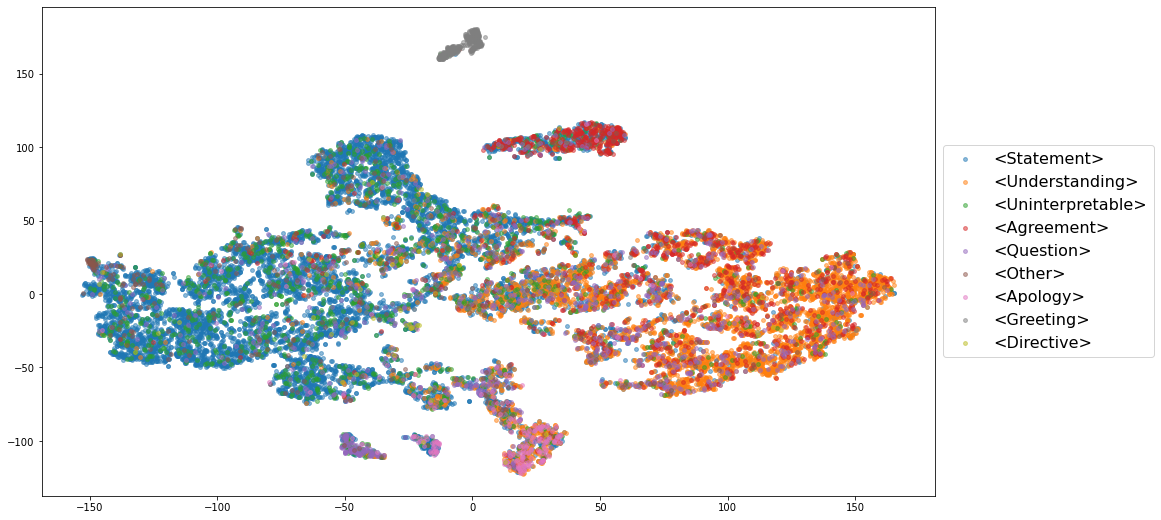

In [68]:
from sklearn.manifold import TSNE
def tSNE_Visization(output, target, t_SNE_path):
        
    tsne = TSNE(n_components=2, random_state=41, n_iter=10000, perplexity=50.0, early_exaggeration=20.0, init='pca')
    X_reduced = tsne.fit_transform(output)
    plt.figure(figsize=(16, 9))
    
    for idx in range(len(DA_vocab.word2id)):
        targets=X_reduced[target==idx]
        plt.scatter(targets[:, 0], targets[:, 1],
                    label=DA_vocab.id2word[idx],
                    cmap='jet',
                    s=15, alpha=0.5)
        # plt.legend()
        
    plt.legend(loc='center left', bbox_to_anchor=(1., .5), fontsize=16)
    plt.savefig(t_SNE_path)
    


t_SNE_path="./img/SwDA/tSNE/" + model_name+loss_name+reductions+"_"+str(config[model_name+loss_name]['EPOCH']) + "_tSNE" +".png"

# targets = []
# for yDA in YDA_test:
#     for y in yDA:
#         targets.append(y)

targets = [yDA[-1] for yDA in YDA_test]
tSNE_Visization(np.array(results), np.array(targets), t_SNE_path)

## Kernel tSNE

In [ ]:
from KtSNE.ktsne import Ktsne

targets = [yDA[-1] for yDA in YDA_test]

f_opts = {'p_degree': 2.0, 'p_dims': 64, 'eta': 25.0,
        'perplexity': 150.0, 'n_dims': 2, 'ker': 'pca', 'gamma': 1.0}

output = np.array(results[:10000])
target = np.array(targets[:10000])

k_tsne = Ktsne(output, f_opts=f_opts)

X_reduced = k_tsne.get_solution(10000)

plt.figure(figsize=(13, 7))
for idx in range(len(DA_vocab.word2id)):
    outputs=X_reduced[target==idx]
    plt.scatter(outputs[:, 0], outputs[:, 1],
                c=target, cmap='jet',
                label=DA_vocab.id2word[idx],
                s=15, alpha=0.5)
    plt.legend()
    
plt.savefig(t_SNE_path)

## 混同行列

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

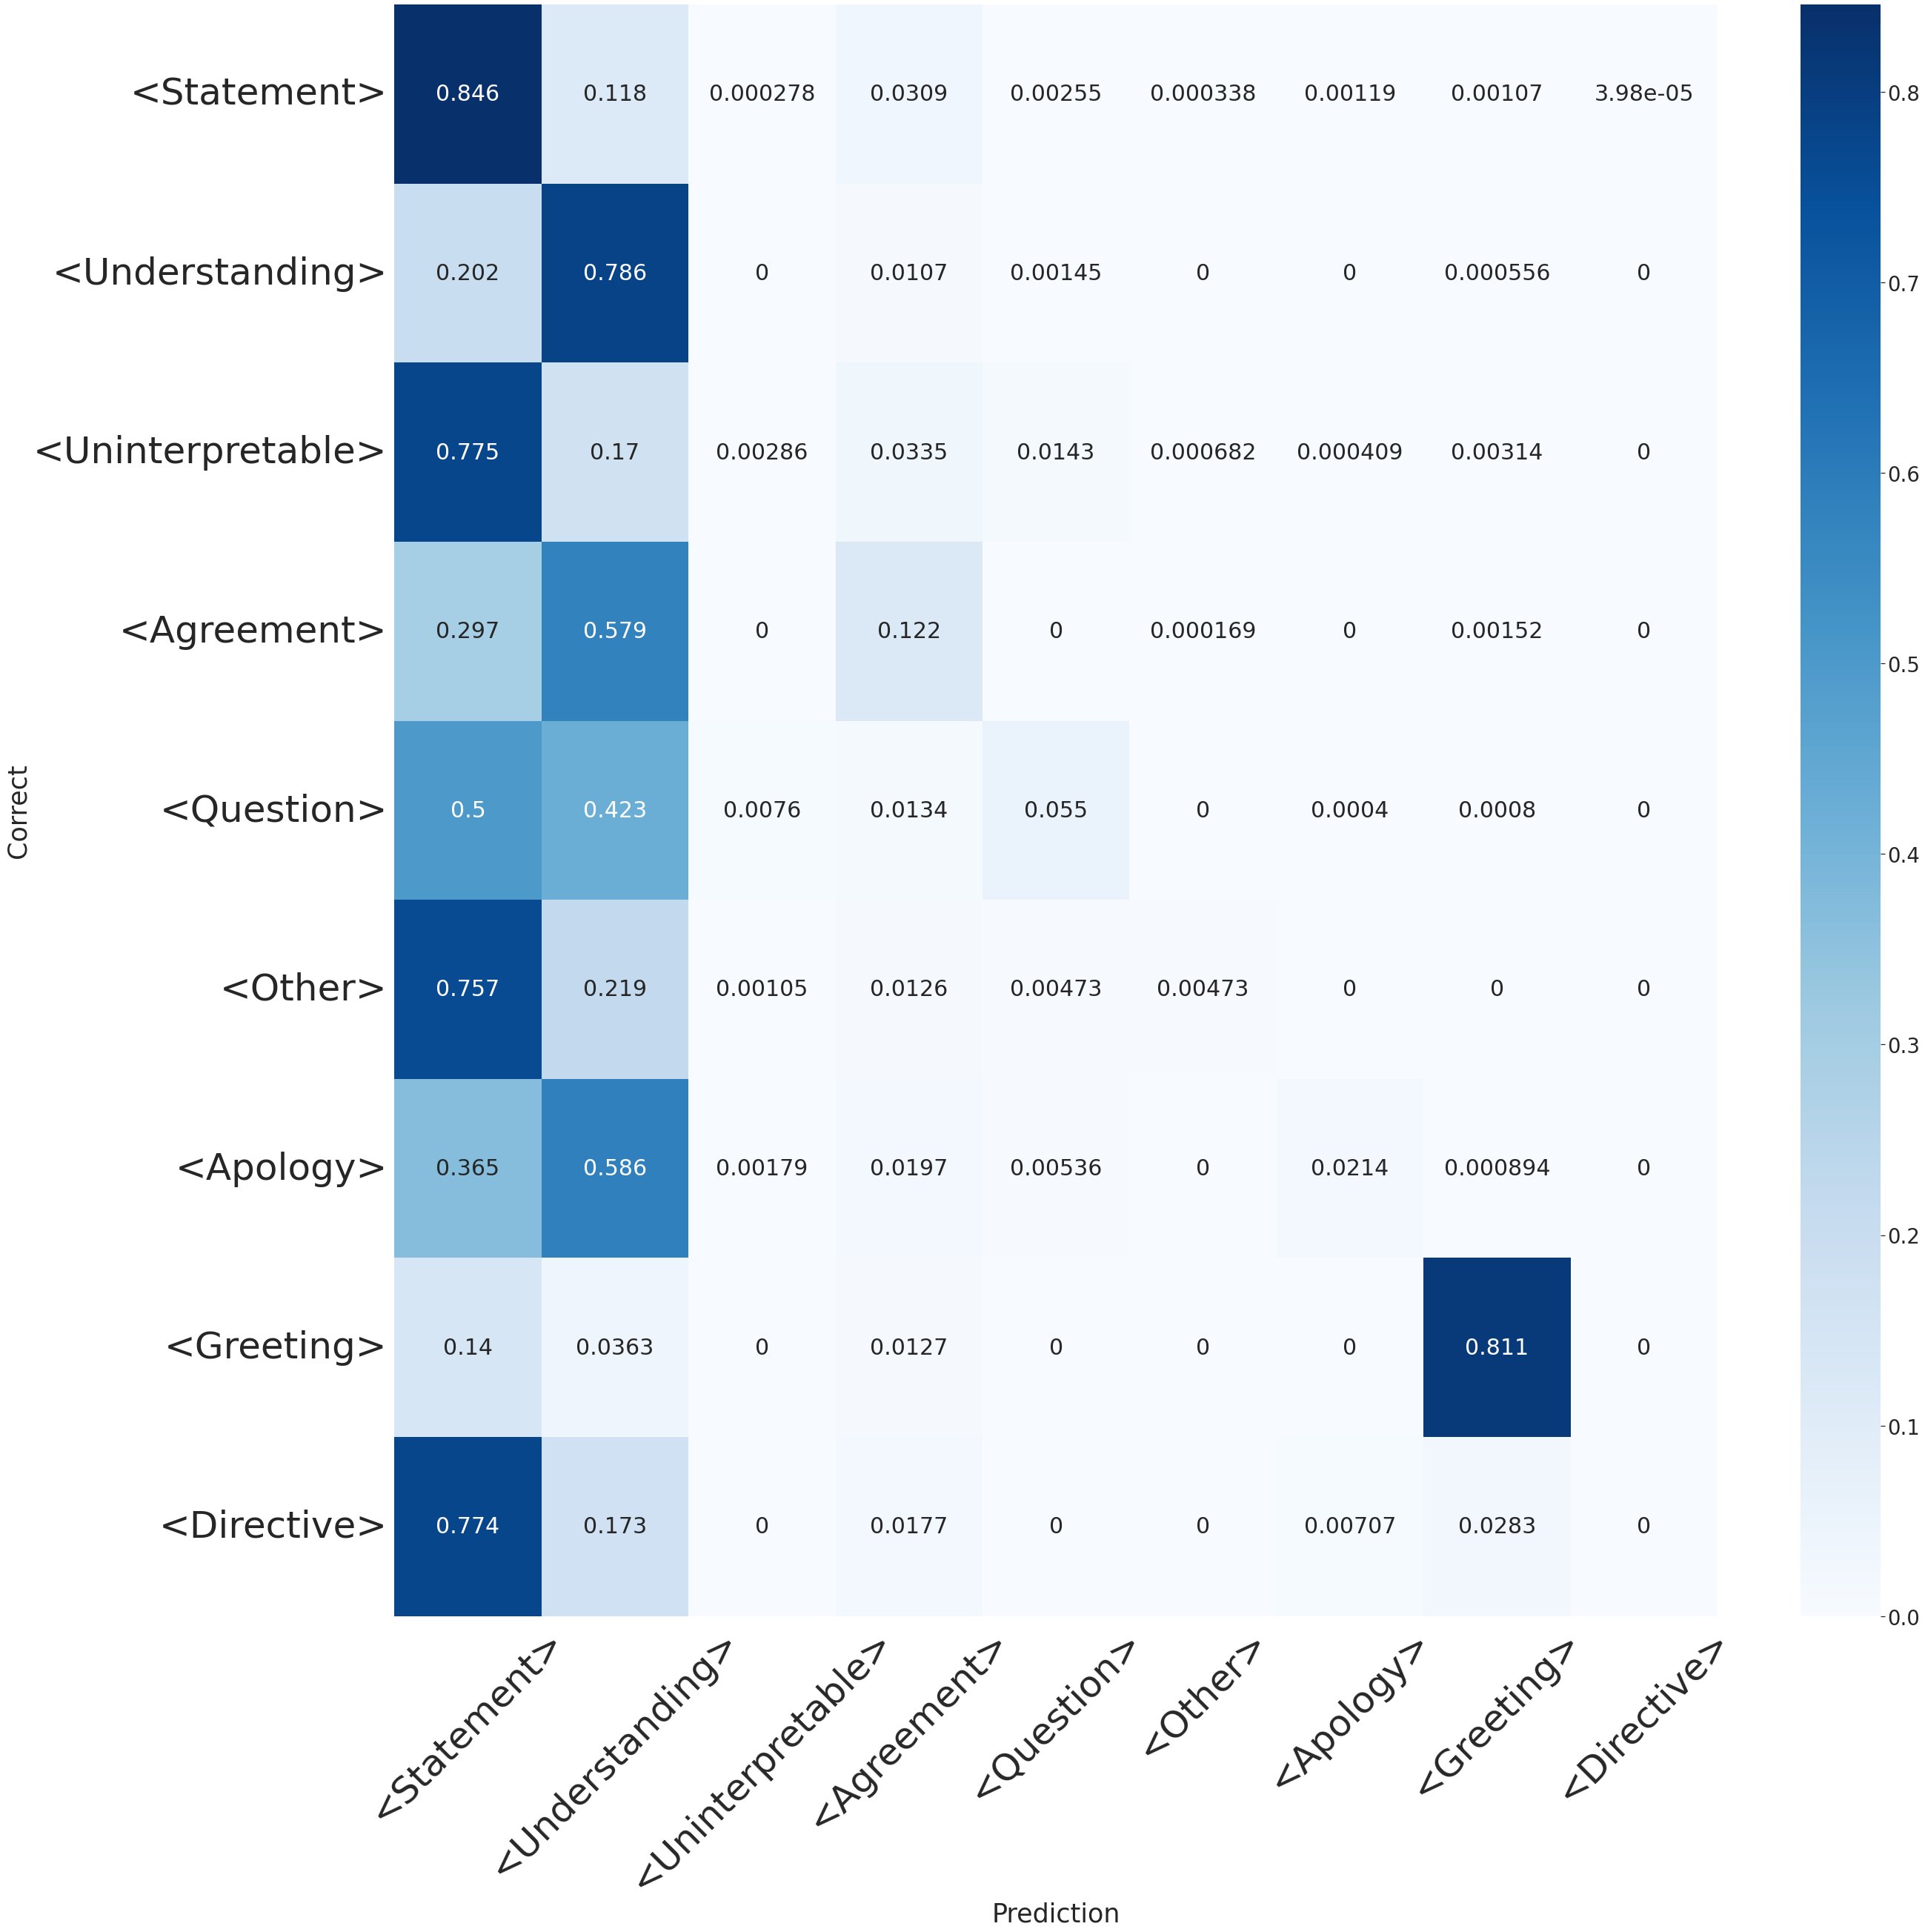

In [48]:
confusion_matrix_path="./img/SwDA/cmx/" + model_name+loss_name+reductions+"_"+str(config[model_name+loss_name]['EPOCH'])+ "_" + str(Pramater_N) +".png"

def CreateConfusionMatrix(result):
    
    labels = []
    for i in range(len(DA_vocab.id2word)):
        labels.append(DA_vocab.id2word[i])
    
    y_true = [label for line in result for label in line['true']]
    y_pred = [label for line in result for label in line['pred']]
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    cm = pd.DataFrame(data=cm,
                     index=labels,
                     columns=labels)
    
    plt.figure(figsize=(40, 40))
    sns.set(font_scale = 2.5)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='.3g')
    plt.xticks(fontsize=50, rotation=45)
    plt.yticks(fontsize=50, rotation = "horizontal")
    plt.xlabel("Prediction", fontsize=35)
    plt.ylabel("Correct", fontsize=35)
    plt.savefig(confusion_matrix_path)
    

# result=ModelTest(model)
CreateConfusionMatrix(result)

### Create Image (Confusion_Matrix)

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [ ]:
def save_cmx(y_true, y_pred, loss_name, num):
    fontsize = 40
    labels = [DA_vocab.id2word[idx] for idx in sorted(list(set(y_true)))]
    y_true_list = [DA_vocab.id2word[idx] for idx in y_true]
    y_pred_list = [DA_vocab.id2word[idx] for idx in y_pred]
    
    cmx_data = confusion_matrix(y_true_list, y_pred_list, labels=labels, normalize='true')

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    plt.figure(figsize=(40, 30))
    plt.rcParams['font.size'] = fontsize
    heatmap = sns.heatmap(df_cmx, annot=True, fmt='.4f', cmap='Blues')
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('./data/images/cmx/cmx_{}_{}.png'.format(loss_name, num))


In [49]:
for re in result[0:4]:
    print(re)
    print("=======================")

{'true': [0, 1, 4, 4, 4], 'true_detok': ['<Statement>', '<Understanding>', '<Question>', '<Question>', '<Question>'], 'pred': [1, 1, 1, 1, 4], 'pred_detok': ['<Understanding>', '<Understanding>', '<Understanding>', '<Understanding>', '<Question>'], 'UttSeq': [['Uh,', 'what', 'kind', 'of', 'house', 'do', 'you', 'live', 'in?'], ['Uh,', 'we', 'live', 'in', 'a', 'one', 'story,', 'just', 'like', 'a', 'style', 'home,', 'you', 'know,', 'the', 'standard', 'Texas,', 'uh,', 'Fox', 'and', '<UNK>'], ['Oh,', 'yeah.'], ['With,', 'with', 'a', 'yard', 'and', 'fence.'], ['How', 'about', 'you', 'guys?']], 'seq_detok': ['<Question>', '<Statement>', '<Understanding>', '<Question>', '<Question>']}
{'true': [1, 4, 4, 4, 0], 'true_detok': ['<Understanding>', '<Question>', '<Question>', '<Question>', '<Statement>'], 'pred': [1, 1, 1, 4, 6], 'pred_detok': ['<Understanding>', '<Understanding>', '<Understanding>', '<Question>', '<Apology>'], 'UttSeq': [['Uh,', 'we', 'live', 'in', 'a', 'one', 'story,', 'just', 'l

In [59]:
for re in result[200:1000]:
    for true_detok, pred_detok in zip(re['true_detok'], re['pred_detok']):
        if true_detok==pred_detok and true_detok=='<Uninterpretable>':
            for UttSeq, seq_detok, true, pred in zip(re['UttSeq'], re['seq_detok'], re['true_detok'], re['pred_detok']):
                strings=""
                for word in UttSeq:
                    strings+=word+" "
                print(strings, seq_detok, true, pred)
            print("================================================================================================================")

Uh-huh.  <Understanding> <Statement> <Statement>
and they want to come home  <Statement> <Statement> <Statement>
and they want some quiet,  <Statement> <Understanding> <Understanding>
<UNK> and try to go to sleep,  <Understanding> <Understanding> <Understanding>
really,  <Understanding> <Uninterpretable> <Uninterpretable>
Yeah,  <Agreement> <Agreement> <Agreement>
exactly,  <Agreement> <Uninterpretable> <Agreement>
we,  <Uninterpretable> <Understanding> <Statement>
Yeah,  <Understanding> <Uninterpretable> <Uninterpretable>
and even,  <Uninterpretable> <Statement> <Statement>
exactly,  <Agreement> <Uninterpretable> <Agreement>
we,  <Uninterpretable> <Understanding> <Statement>
Yeah,  <Understanding> <Uninterpretable> <Uninterpretable>
and even,  <Uninterpretable> <Statement> <Statement>
you know, I mean, like we had, I called them <UNK> just a tract home,  <Statement> <Statement> <Statement>
Well, I don't, I mean, I don't know what you think about the, subject,  <Question> <Statement> <